# Прогнозирование количества заказов такси на следующий час

В данной работе необходимо на основе исторических данных о заказах такси в аэропорт спрогнозировать количество заказов такси на следующий час с целью привлечь необходимое количество машин в аэропорт.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## План работы

### Шаг 1. Загрузка и ресемплирование данных
- [1. Импорт библиотек, загрузка, ресемплирование](#section1)

### Шаг 2. Анализ данных
- [1. Анализ ресемплированных данных](#section2)

### Шаг 3. Обучение моделей
- [1. Создание класса трансформации признаков](#section3)
- [2. Разделение датафрейма на выборки, разделение на фолды](#section4)
- [3. Создание и выполнение пайплайна](#section5)
- [4. Проверка лучшей модели на тестовой выборке, проверка на адекватность](#section6)

## Шаг 1. Загрузка и ресемплирование данных

<a id='section1'></a>

#### 1. Импорт библиотек, загрузка, ресемплирование

Для начала импортируем все библиотеки, потребующиеся в данной работе.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from IPython.display import Image

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

Далее прочитаем файл с данными и изучим общую информацию.

In [2]:
# Путь к файлу на локальном компьютере
path = 'datasets/taxi.csv'

df = pd.read_csv(path, index_col=[0], parse_dates=[0])
print('Даты расположены в хронологическом порядке:', df.index.is_monotonic)
df.info()
df.head()

Даты расположены в хронологическом порядке: True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные состоят всего из двух столбцов - datetime (дата и время) и num_orders (количество заказов такси). Пропусков нет. Ресемплируем данные по часу.

In [3]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Шаг 2. Анализ данных

<a id='section2'></a>

#### 1. Анализ ресемплированных данных

Проанализируем ресемплированный датасет. Для начала изучим распределение данных.

In [4]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Теперь визуализируем данные.

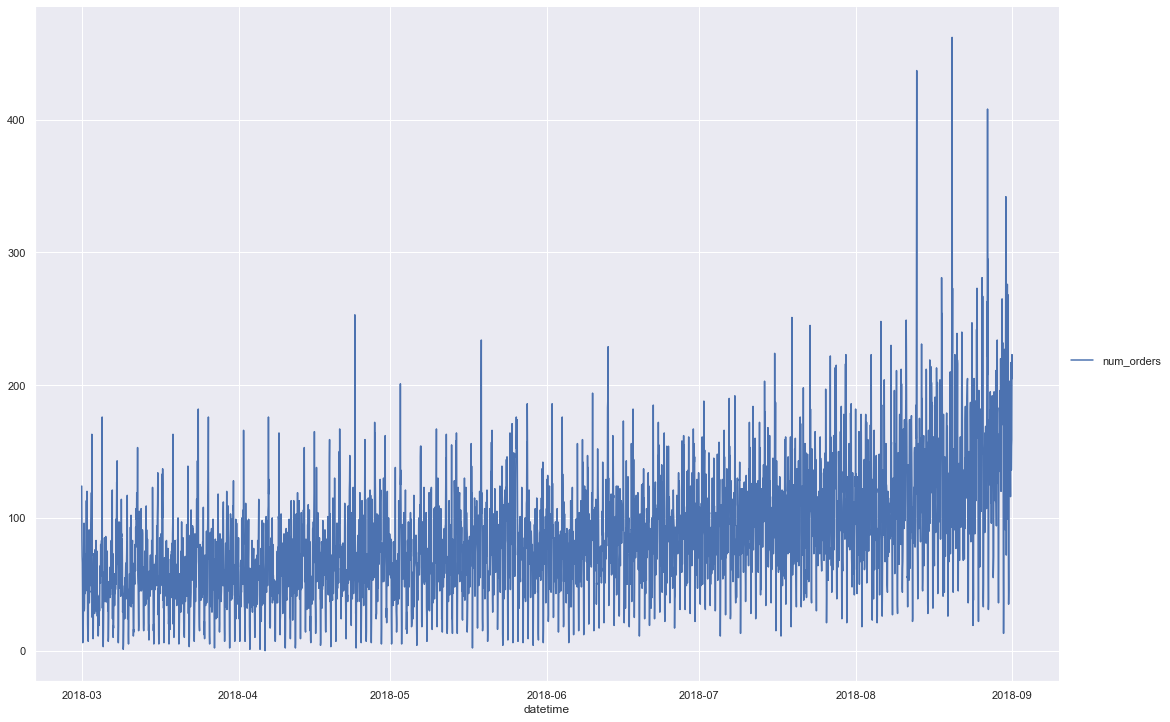

In [5]:
sns.set()
sns.relplot(data=df,
            kind='line',
            height=10,
            aspect=1.5
           )
plt.show()

Представленный график пока не позволяет выявить какие-либо закономерности, но по нему уже видно, что срееднее количество заказов с каждым месяцем увеличивается. Убедимся в этом, выявив тренд и сезонность.

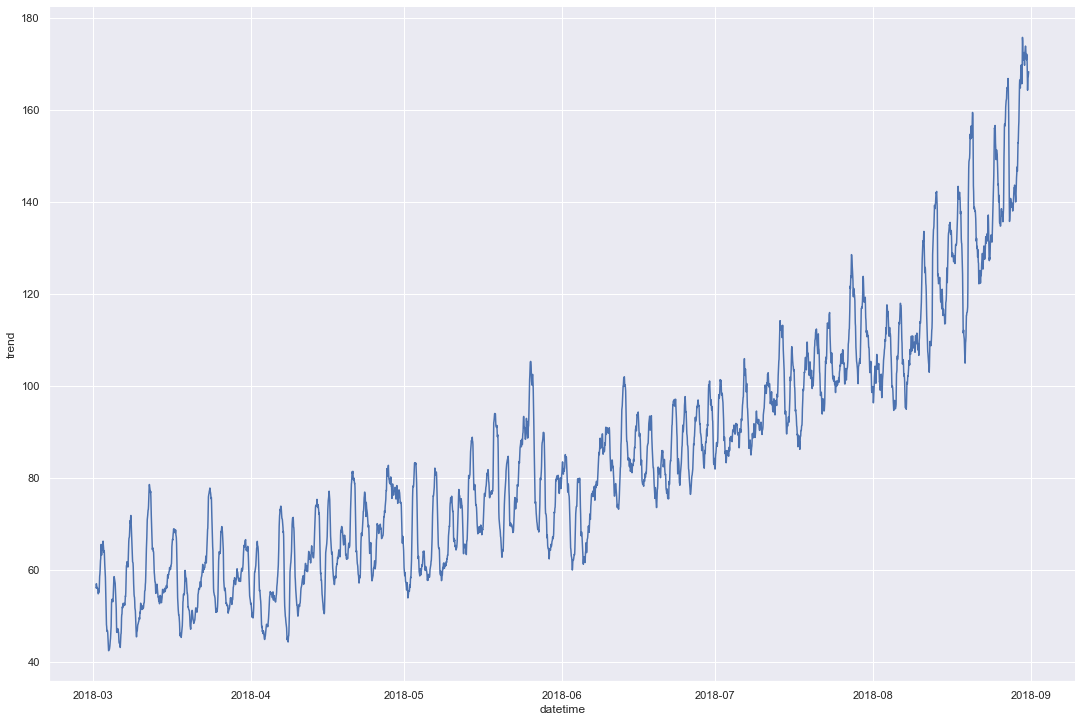

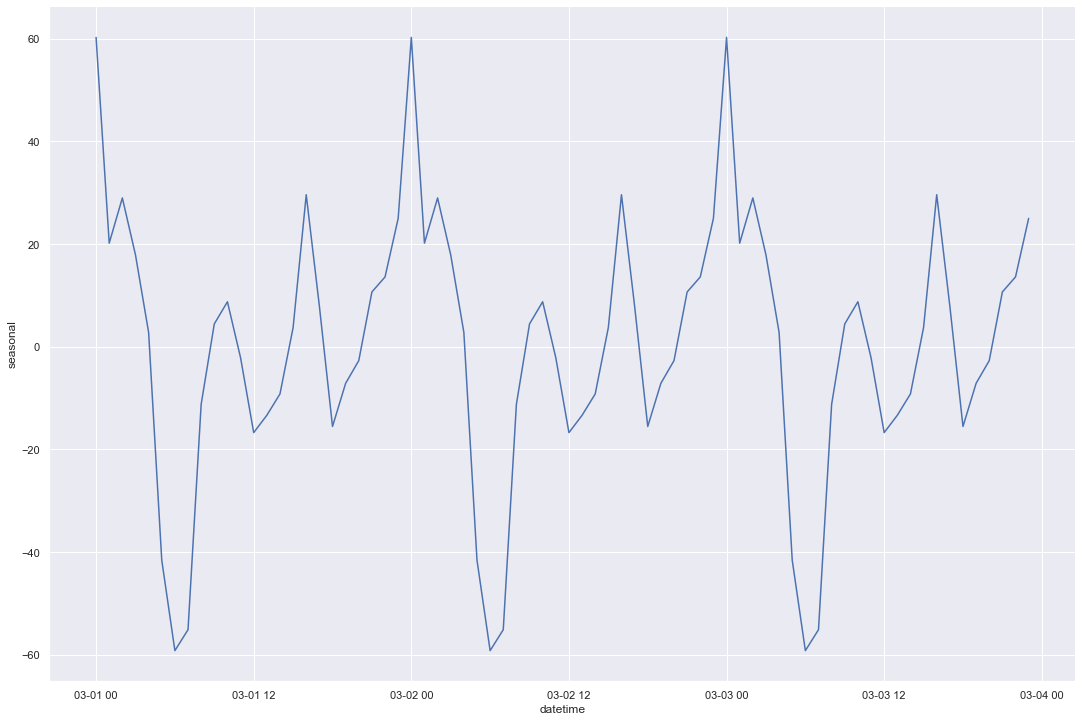

In [6]:
decomposed = seasonal_decompose(df)
sns.relplot(data=decomposed.trend,
            kind='line',
            height=10,
            aspect=1.5
           )
plt.show()
sns.relplot(data=decomposed.seasonal['2018-03-01':'2018-03-03'],
            kind='line',
            height=10,
            aspect=1.5
           )
plt.show()

Действительно количество заказов увеличивается каждый месяц. Сезонность показывает, что каждый день есть четкая закономерность по числу заказов на протяжении дня: меньше всего заказов ночью, особенно в 6 часов утра, затем количество заказов увеличивается и достигает своего пика в полночь.

## Шаг 3. Обучение моделей

<a id='section3'></a>

#### 1. Создание класса трансформации признаков

Прежде, чем приступать к обучению моделей, добавим новые признаки в датасет. Для этого создадим класс, осуществляющий трансформацию признаков.

In [7]:
class MakeFeatures(BaseEstimator, TransformerMixin):
    def __init__ (self, max_lag, rolling_mean_size):
        '''
        max_lag - максимальное количество добавляемых отставаний
        rolling_mean_size - размер скользящего окна для вычисления среднего
        '''
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size
        
    def fit(self, X, y=None):        
        return self
    
    def transform(self, X, y=None):        
        X_ = X.copy()
        # Добавим месяц
        X_['month'] = X_.index.month
        # Добавим день
        X_['day'] = X_.index.day
        # Добавим день недели
        X_['dayofweek'] = X_.index.dayofweek
        # Информация о заказах в прошлые часы
        for lag in range(1, self.max_lag + 1):
            X_['lag_{}'.format(lag)] = X['num_orders'].shift(lag)            
        # Скользящее среднее за прошлые часы
        X_['rolling_mean'] = X['num_orders'].shift().rolling(self.rolling_mean_size).mean()       
        return X_

<a id='section4'></a>

#### 2. Разделение датафрейма на выборки, разделение на фолды

Добавим новые признаки. Разделим признаки и целевой признак.

In [8]:
mf = MakeFeatures(48, 24)
X_and_y = mf.transform(df)

#Удалим пропуски
X_and_y.dropna(inplace=True)

# Отделим целевой признак от остальных
X = X_and_y.drop('num_orders', axis=1)
y = X_and_y['num_orders']

X.head()

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,3,3,5,72.0,119.0,101.0,93.0,49.0,89.0,83.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,62.750000
2018-03-03 01:00:00,3,3,5,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,65.791667
2018-03-03 02:00:00,3,3,5,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,65.291667
2018-03-03 03:00:00,3,3,5,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,63.208333
2018-03-03 04:00:00,3,3,5,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,63.208333


Теперь разделим датафрейм на выборки.

In [9]:
# Разделим на тренировочную, валидационную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

# Создадим метрику на основе MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

Обычную кросс-валидацию на временных рядах делать нельзя, поэтому воспользуемся TimeSeriesSplit() для разбиения на фолды в соответствии с представленным ниже рисунком.

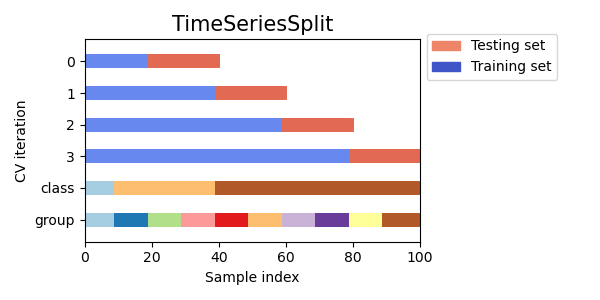

In [10]:
Image('https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_010.png')

In [11]:
tscv = list(TimeSeriesSplit(n_splits=8).split(X_train, y_train))

<a id='section5'></a>

#### 3. Создание и выполнение пайплайна

Теперь сформируем пайплайн для выполнения кросс-валидации. В качестве моделей будем использовать линейную регрессию, дерево решений, случайный лес и модель градиентного бустинга (LGB). 

In [12]:
random_state = 321

# Сформируем пайплайн
estimators = [('model', LinearRegression())]
pipe = Pipeline(estimators)

# Зададим варианты изменения гиперпараметров
param_grid = [{'model': [LinearRegression()]
              },
              {'model': [DecisionTreeRegressor(random_state=random_state)],
               'model__max_depth': range(1, 22, 5),
               'model__min_samples_split': range(2, 23, 5),
               'model__min_samples_leaf': range(1, 22, 5),
              },
              {'model': [RandomForestRegressor(random_state=random_state)],               
               'model__min_samples_split': range(2, 23, 5),
               'model__min_samples_leaf': range(1, 22, 5),
              },
              {'model': [LGBMRegressor()],
               'model__num_leaves': range(6, 32, 5),
               'model__learning_rate': [0.005, 0.01, 0.05, 0.2, 0.5],
              },
              {'model': [CatBoostRegressor(verbose=250)]               
              }  
             ]

Выполним поиск лучшего сочетания гиперпараметров с помощью кросс-валидации.

In [13]:
# Опишем GridSearchCV
grid = GridSearchCV(pipe,
                    param_grid,                          
                    scoring=mse_scorer,
                    n_jobs=-1,
                    cv=tscv                          
                   )

In [14]:
%%time
grid.fit(X_train, y_train)

Learning rate set to 0.049799
0:	learn: 37.7776734	total: 149ms	remaining: 2m 28s
250:	learn: 18.3305623	total: 2.27s	remaining: 6.76s
500:	learn: 14.6247014	total: 4.51s	remaining: 4.49s
750:	learn: 12.0910392	total: 6.49s	remaining: 2.15s
999:	learn: 10.0710106	total: 8.52s	remaining: 0us
Wall time: 3min 55s


GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108...
                         {'model': [RandomForestRegressor(random_state=321)],
                          'model__min_samples_leaf': range(1, 22, 5),
                          'model__min_samples_split': range(2, 23, 5)},
                         {'model': [LGBMRegressor()],
                          'model__learning_rate': [0.005, 0.01, 0.05, 0.2, 0.5],
                 

In [15]:
# Получим лучшую модель
pipe = grid.best_estimator_
pipe

Pipeline(steps=[('model',
                 <catboost.core.CatBoostRegressor object at 0x0000027F4BA3F880>)])

In [16]:
print('RMSE лучшей модели на тренировочной выборке =', (grid.best_score_ * (-1)) ** 0.5)

RMSE лучшей модели на тренировочной выборке = 23.337876305010365


<a id='section6'></a>

#### 4. Проверка лучшей модели на тестовой выборке, проверка на адекватность

Проверим лучшую модель на тестовой выборке

In [17]:
pipe.fit(X_train, y_train)
print('RMSE лучшей модели на тестовой выборке =', mean_squared_error(y_test, pipe.predict(X_test))**0.5)

Learning rate set to 0.049799
0:	learn: 37.7776734	total: 10.4ms	remaining: 10.4s
250:	learn: 18.3305623	total: 2.39s	remaining: 7.14s
500:	learn: 14.6247014	total: 4.67s	remaining: 4.66s
750:	learn: 12.0910392	total: 6.84s	remaining: 2.27s
999:	learn: 10.0710106	total: 9.16s	remaining: 0us
RMSE лучшей модели на тестовой выборке = 39.42875869853335


Проверим модель на адекватность. Для этого сравним результаты с моделью, выдающей всегда один и тот же прогноз. Затем сравним результаты с моделью, выдающей предыдущее значение.

In [18]:
pred_const = np.ones(len(y_test)) * y_train.mean()
print('RMSE константной модели на тестовой выборке =', mean_squared_error(y_test, pred_const)**0.5)

RMSE константной модели на тестовой выборке = 84.73905254961741


In [19]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print('RMSE модели, предсказывающей предыдущее значение, на тестовой выборке =', mean_squared_error(y_test, pred_previous)**0.5)

RMSE модели, предсказывающей предыдущее значение, на тестовой выборке = 59.01904048345839


Проверку на адекватность модель прошла.

Теперь визуализируем предсказания модели и сравним их с тестовыми данными.

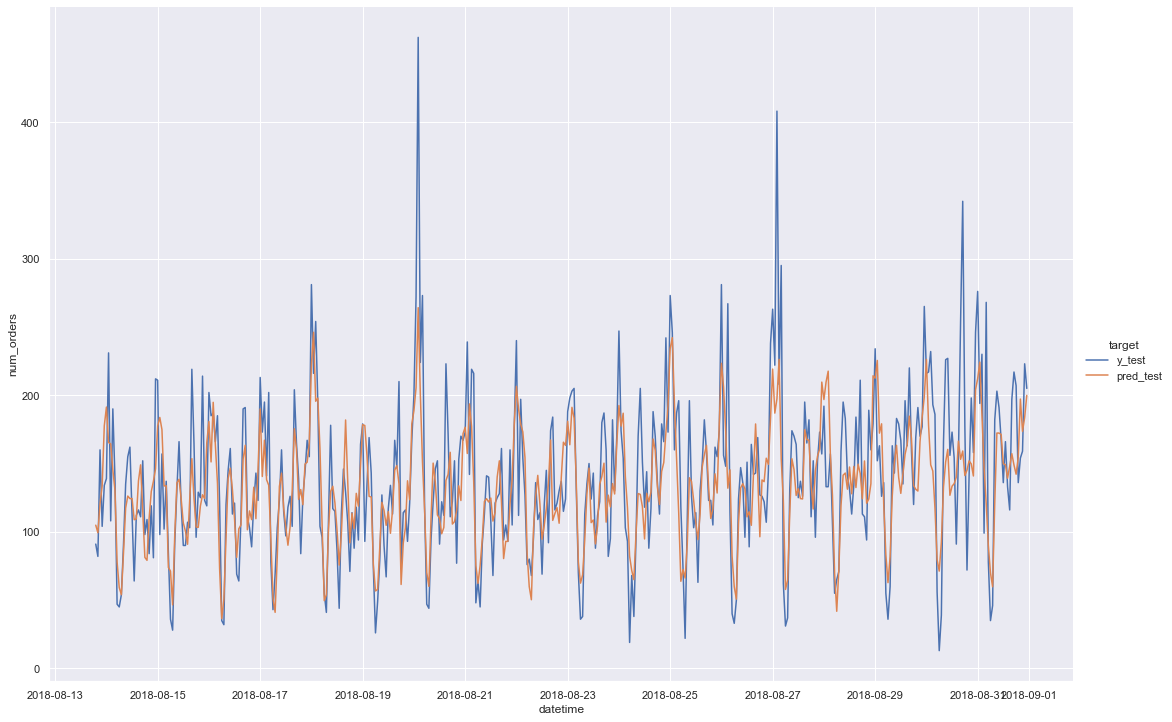

In [20]:
pred_test = pd.DataFrame(pipe.predict(X_test), columns=['num_orders'], index=y_test.index)
y_test = pd.DataFrame(y_test)
df_y_pred = pd.concat([y_test.assign(target='y_test'), pred_test.assign(target='pred_test')])
sns.relplot(data=df_y_pred,
            x=df_y_pred.index,
            y='num_orders',
            hue='target',
            height=10,
            aspect=1.5,
            kind='line'
           )
plt.show()

По данному графику легко заметить, что в первые дни предсказания довольно близки к реальным значениям, но чем дальше - тем больше предсказания "промахиваются". Хотя уловить тренд модель смогла.

## Вывод

В ходе выполнения работы была получена модель, позволяющая делать предсказания количества заказов такси в каждый час в будущем. Модель CatBoost с параметрами "из коробки" показала результат лучше, чем другие модели с оптимизированными параметрами.RMSE  модели на тестовой выборке составил 39,4, что значительно меньше 48, требуемых по условию. Также было подтверждено, что модели машинного обучения могут хорошо предсказывать изменение данных в очень недалеком будущем. Однако предсказания более далеких событий начинают расходиться с реальными данными.